<a href="https://colab.research.google.com/github/nishi-patel-15/motor_rnn_target_performance/blob/Dylan's-Branch/Master_Copy_DY_Motor_RNNs_TargetPerformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [39]:
# import python packages
import os
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from IPython import display

In [40]:
# @title Set the project path
proj_path = "proj_rnn/"
if not os.path.exists(proj_path):
  os.makedirs(proj_path)

# set the directories where the results will be saved
savedir = os.path.join(proj_path, 'data/fig2/')
if not os.path.exists(savedir):
  os.makedirs(savedir)

## Utils

### Network

In [41]:
# @title RNN encoder
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r
        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        """
        Args
          self.z: RNN network's activation
          trials: Number of learning episodes
          ext (np.array): stimuli (n_targets, n timesteps, n_targets?)
          nstart: first learning index
          decoder (np.array): (N units, 2d coordinates) decoder weights
          feedback (np.array): (N units, 2d coordinates) feedback weights
          target: (n_targets, N timesteps, 2d coordinates) target coordinates
          delta: regularization parameter for the RLS learning rule.
          wplastic: (optional) which connections are plastic (modifiable). If None then ALL modifiable.

        Returns:

          loss (np.array): loss by trial
        """
        # get number of timesteps within trial
        tsteps = ext.shape[1]

        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]   #Any non-zero recurrent connection is plastic.
        else:
            self.W_plastic = wplastic                                           #????
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))] #Each neuron gets a P matrix, which is the inverse correlation matrix used in Recursive Least Squares (RLS) learning. It controls how the weights are updated.

        # create n trials of target indices chosen from lenth of total stimuli options
        order = np.random.choice(range(ext.shape[0]), trials, replace=True)     #Randomly picks stimuli indices to use in each trial (with replacement).

        # initialize calculated loss per trial
        record_loss = np.zeros(trials)

        # loop over trials
        for t in range(trials):

            # initialize loss
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.                            # Random initial activation
            self.update_activation()

            # loop over time
            for i in range(1,tsteps):

                # update units
                self.update_neurons(ext=ext[order[t],i])

                # learn
                if i > ntstart and i%2==0:                                      #learning only occurs after the pulse_length/center screen time and on every second trial.

                    # decode network's predicted
                    # target coordinates
                    c = decoder @ self.z                                        #Projects current activity (z) onto 2D space (decoder)

                    # calculate prediction error between
                    # decoded and true target coordinates (2,)
                    errc = c - target[order[t], i]                              #Difference in predicted position (c) and actual target position at current time.

                    # calculate the error update assigned to each weight
                    err1 = feedback @ errc                                      #projected back into neuron space via feedback matrix — i.e., which neurons are responsible for this error.

                    # calculate loss
                    loss += np.mean(err1**2)

                    # update plastic recurrent weights
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]                   #Only update plastic synapses
                        pz = np.dot(self.P[j], z_plastic)                       #Filtered input vector
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm

                        # use error-transformed feedbacks to update
                        # plastic weights
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm     #Amount of change proportional to error assigned to current neuron (j), filtered input activity (pz), and normalized by norm.

            # tape loss
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):                         #ext = stimuli
        tsteps = ext.shape[1]                                                   #tsteps = length of stimuli
        T = self.dt*tsteps                                                      #T = real time
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))                             #store activity[timepoints,N]
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)       #chose a random trial
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])                         #runs simulate on selected trial at all times
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]                   #stores in activity array (only after ntstart)
        cov = np.cov(activity.T)                                                #Covariance of activity(N,trial time points)
        ev,evec = np.linalg.eig(cov)                                            #eigenvalue and eigenvector from cov
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)        #Participation Ratio (PR): a measure of effective dimensionality of the manifold (See fig 3 of original paper)
        xi = activity @ evec.real                                               #transformed activity profile into PCA space
        return activity,cov,ev.real,evec.real,pr,xi,order

def save_RNN(network, savedir:str):
  """write RNN object and weights in savedir
  """
  network.save(savedir+'network')
  np.save(savedir+'W_initial', network.W)

def save_RNN_sinewave(network, savedir:str):
  """write RNN sinewave object and weights in savedir
  """
  network.save(savedir + 'network_sinewave')
  np.save(savedir + 'W_initial_sinewave', network.W)

In [42]:
# @title BCI decoders
def train_reaching_decoder(inputP, target, order, n_output_units:int=2):        ###inputP = get manifold output["xi2"][:, :, :reduced_dim #Target is get reaching targets output # Order is from manifold output as well # last is obvious idiot
    """train the decoder to perform the six-cue
    motor reaching task
    """
    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))           #X: Flattened neural data, shape = (total_timepoints, n_neurons)

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output_units))             #Y: Flattened target output, shape = (total_timepoints, n_output_units)

    # fill up (This effectively flattens the trial-based data into one long array suitable for regression)
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]                #Fills in data from manifold
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]         #Fills in data from target task

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X,Y)                                                                #Trains a linear model: Y ≈ X * coef + bias

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse                                                       #reg.coef_: The weight matrix (shape = (n_output_units, n_neurons)), representing how each neuron's activity contributes to each output dimension. mse is performance

def create_reaching_task_decoder(reaching_network, n_output_units:int=2, target_max:float=0.2):
  """create feedforward decoder from RNN to (x,y) output units
  for learning (random weights)"""                                              #By 'create' really just makes a matrix suitable for learning the proper weights.

  # set parameters
  SCALE = 0.04
  DENOM = 0.2

  # create random weights
  reaching_decoder = np.random.randn(n_output_units, reaching_network.N)        #Creates a random weight matrix of shape (2, N) where N is the number of neurons.
  initial_decoder_fac = SCALE * (target_max / DENOM)                            #Target max defined in parameters; max x,y distance of target

  # normalize decoder matrix
  reaching_decoder *= (initial_decoder_fac / np.linalg.norm(reaching_decoder))  #Scales the entire decoder matrix so that its norm matches initial_decoder_fac. Ensures that the initial decoder produces outputs of a reasonable magnitude (neither too small nor too large) — useful for stable learning.
  return reaching_decoder                                                       #This computes the Frobenius norm (Euclidean norm for a matrix), which is: look it up, Upshot it its the magnitude of the full RNN matrix
                                                                                #reaching_decoder *=  scalar. This scales every element in the reaching_decoder matrix by that scalar. The operation is in-place because of the *= operator, meaning it modifies the matrix directly rather than returning a new one.

def train_force_exertion_decoder(inputP, target, order, n_output:int=1):        #Similar in structure to train_reaching_decoder. Unused in base data.
    """train the decoder to perform the force exertion
    motor task. The network must apply force at
    oscillating amplitude (following a sinewave function
    of time)
    """

    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X, Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

In [43]:
# @title Feedback weights
def get_feedback_weights(decoder):                                              #Still not sure exactly what is going on. Isn't input essentially blank here?
  """calculate feedback weights from (x,y) output units back to RNN
  as the matrix inverse of the feedforward decoder weights from the RNN to
  the output units"""
  return np.linalg.pinv(decoder)

In [44]:
# @title Loss function
def get_cost(result, target, order):                                            #Part of transform_reaching. Calculates the mean squared difference between the end results and the target
  cost = 0
  for j in range(result.shape[0]):
    error = result[j, :, :] - target[order[j], :, :]
    cost += np.mean(error**2)
  return cost

In [45]:
# @title PLot Loss
def plot_loss_over_trials(losses):
    trials = len(losses)
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, trials + 1), losses, marker='o', linestyle='-')
    plt.xlabel("Trial")
    plt.ylabel("Loss")
    plt.title("Loss per Trial")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [46]:
# @title Get the manifold
def get_manifold(network):

  # calculate the manifold
  activity, cov, ev, evec, pr, xi, order = network.calculate_manifold(trials=manifold_trials, ext=stimulus, ntstart=pulse_length)

  # reshape the activity
  activity_reshaped = activity.reshape(manifold_trials, -1, network.N)
  xi2 = xi.reshape(manifold_trials, -1, network.N)
  return {"xi2":xi2, "order":order, "xi":xi, "cov":cov, "ev":ev, "evec":evec, "pr":pr,"activity":activity, "activity_reshaped":activity_reshaped}

def save_reaching_manifold(data, T):
  dic = {'manifold': {'original': data['manifold']}, 'perturbations': {'transformed':T}}
  np.save(savedir + 'reaching_relearning_results', dic)

def transform_reaching(reaching_network, manifold_out, W_bci4, n_output_units:int=2):

  P = manifold_out["evec"].real.T
  D = np.zeros((2, reaching_network.N))
  D[:,:reduced_dim] = W_bci4
  transformed = D @ P
  result = manifold_out["activity_reshaped"] @ transformed.T
  cost = get_cost(result, target[:,pulse_length:,:], manifold_out["order"])
  return transformed

### Task

In [78]:
# @title "reaching" task
def create_reaching_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=6, amplitude:float=1., twod:bool=False):
    """create the set of stimuli, which we sample from at each trial

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float):
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimulus
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_reaching_task_targets(tsteps, pulse_steps, n_targets:int=6, stype='constant', target_max:float=0.2):
    """create the set of target coordinates (6 by default) that the network
    must reach before the end of a trial. The network starts from the center of
    the computer screen (coordinate: (0,0))
    """
    # create target trajectories
    phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
    rs = np.zeros(tsteps)

    # define each target's x and y coordinate
    rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max                   #Stimuli start at 0,0 then move to final position at 'pulse_steps'
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):

        # create x-coordinate on screen
        traj[j,:,0] = rs*np.cos(phis[j])

        # create y-coordinate on screen
        traj[j,:,1] = rs*np.sin(phis[j])
    return traj

def create_reaching_task_targets_trials(tsteps, pulse_steps, n_targets:int=6, learning_trials:int=80, stype='constant', target_max:float=0.2):
    """
    Create the set of target coordinates (6 by default) that the network
    must reach before the end of a trial. The network starts from the center of
    the screen (coordinate: (0,0)).

    Parameters:
        tsteps (int): total number of time steps per trial
        pulse_steps (int): time step at which stimulus starts (before which target = 0)
        n_targets (int): number of different targets
        stype (str): 'constant' for evenly spaced targets, 'random' for random target directions
        target_max (float): max radius of target position (e.g., 0.2)

    Returns:
        traj (ndarray): shape (n_targets, tsteps, 2), target trajectories
    """

    rs = np.zeros(tsteps)
    rs[pulse_steps:] = target_max  # Targets are at origin until pulse, then jump to outer radius

    if stype == 'constant':
        phis = np.linspace(0, 2 * np.pi, n_targets, endpoint=False)
        traj = np.zeros((n_targets, tsteps, 2))
        for j in range(n_targets):
            traj[j, :, 0] = rs * np.cos(phis[j])
            traj[j, :, 1] = rs * np.sin(phis[j])
    elif stype == 'random':
        phis = np.random.uniform(0, 2 * np.pi, size=learning_trials)
        traj = np.zeros((learning_trials, tsteps, 2))
        for j in range(learning_trials):
            traj[j, :, 0] = rs * np.cos(phis[j])
            traj[j, :, 1] = rs * np.sin(phis[j])
    else:
        raise ValueError(f"Unrecognized stype '{stype}'. Use 'constant' or 'random'.")

    return traj

def create_reaching_task_targets_test(tsteps, pulse_steps, n_targets:int=6, stype='constant', target_max:float=0.2):
    """
    Same as default reaching, but used for testing

    Parameters:
        tsteps (int): total number of time steps per trial
        pulse_steps (int): time step at which stimulus starts (before which target = 0)
        n_targets (int): number of different targets
        stype (str): 'constant' for evenly spaced targets, 'random' for random target directions
        target_max (float): max radius of target position (e.g., 0.2)

    Returns:
        traj (ndarray): shape (n_targets, tsteps, 2), target trajectories
    """
    if stype == 'constant':
        phis = np.linspace(0, 2 * np.pi, n_targets, endpoint=False)

    else:
        raise ValueError(f"Unrecognized stype '{stype}'. Use 'constant' or 'random'.")

    rs = np.zeros(tsteps)
    rs[pulse_steps:] = target_max  # Targets are at origin until pulse, then jump to outer radius

    traj = np.zeros((n_targets, tsteps, 2))
    for j in range(n_targets):
        traj[j, :, 0] = rs * np.cos(phis[j])
        traj[j, :, 1] = rs * np.sin(phis[j])

    return traj

def plot_reaching_task_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginning of each trial
  stimulus_set = np.arange(0, n_targets,1)

  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))

  for target in stimulus_set:
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)

  axes[-1].set_xlabel("time within a trial (secs)")

  fig.tight_layout()

  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def plot_reaching_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6))
  for target_i in tuple(range(n_targets)):
    axes[target_i].plot(target[target_i,:,:])

    # legend
    axes[target_i].set_xticks([0, tsteps])
    axes[target_i].set_xticklabels([0, T])
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9)
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01])
    # axes[target_i].legend(["x-coord", "y-coord"], fontsize=9, frameon=False)


  axes[-1].set_xlabel("time within a trial (secs)")
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False)

  fig.tight_layout()

In [49]:
# @title "force" task
def create_force_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=1, amplitude:float=1., twod:bool=False):
    """create a stimulus set

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float)
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimuli
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    for j in range(n_targets):
        stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def plot_force_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginning of each trial
  stimulus_set = np.arange(0, n_targets, 1)
  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))
  for target in stimulus_set:

    # plot
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)
  axes[-1].set_xlabel("time within a trial (secs)")
  fig.tight_layout()
  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def create_force_task_targets(tsteps, pulse_steps, targets:list=[1, 10], target_max:float=0.2):
  """exert force with an oscillatorily increasing and decreasing amplitude
  """
  n_targets = len(targets)
  rs = np.zeros(tsteps)
  traj = np.zeros((n_targets, tsteps, 1))
  rs[pulse_steps:] = np.ones(tsteps - pulse_steps) * target_max
  x_coord = np.linspace(-2*np.pi, 2*np.pi, tsteps, endpoint=False)
  freq = []
  for ix in range(n_targets):
    traj[ix,:,0] = rs * np.sin(targets[ix] * x_coord)
  return traj

def plot_force_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6));
  for target_i in tuple(range(n_targets)):

    # plot
    axes[target_i].plot(target[target_i,:,:]);

    # legend
    axes[target_i].set_xticks([0, tsteps]);
    axes[target_i].set_xticklabels([0, T]);
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9);
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01]);
  axes[-1].set_xlabel("time within a trial (secs)");
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False);
  fig.tight_layout();

## Create task 1: "reaching"

In [72]:
# @title set parameters
# TODO: create dictionary

seed_id = 2                 # random seed for this simulation
np.random.seed(seed_id)

# time parameters
dt = 0.01                   # time discretization (secs, see paper table 1)
T = 5                       # trial duration (secs, see paper table 1)
time = np.arange(0, T, dt)
tsteps = len(time)          # number of time steps within a trial
pulse_length = int(0.2/dt)  # pulse length in number of timesteps

# network parameters
N = 400                     # RNN number of units
g = 1.5                     # RNN recurrent connection strengths (a.u)
p = 0.1                     # RNN connection probability
tau = 0.1                   # unit time constant tau (secs)
N_OUTPUT_UNITS = 2          # number of output units (2 for x and y)

# task parameters
targets = 6                 # number of reaching targets
stimulus_type = 'random'  # constant, random (linear, normal)
target_max = 0.2            # 0.2 or 0.01
n_learning1_trials = 5       # initial network learning
delta = 20.
relearning_trials = 80     # relearning
deltarec = 20.

# analyses parameters
manifold_trials = 50        # manifold calculation
reduced_dim = 10

stimuli:
-a set of 6 possible trial stimuli (panels)
-500 timesteps within a trial stimulus
-6 possible cued target in a trial stimulus


IndexError: index 5 is out of bounds for axis 0 with size 5

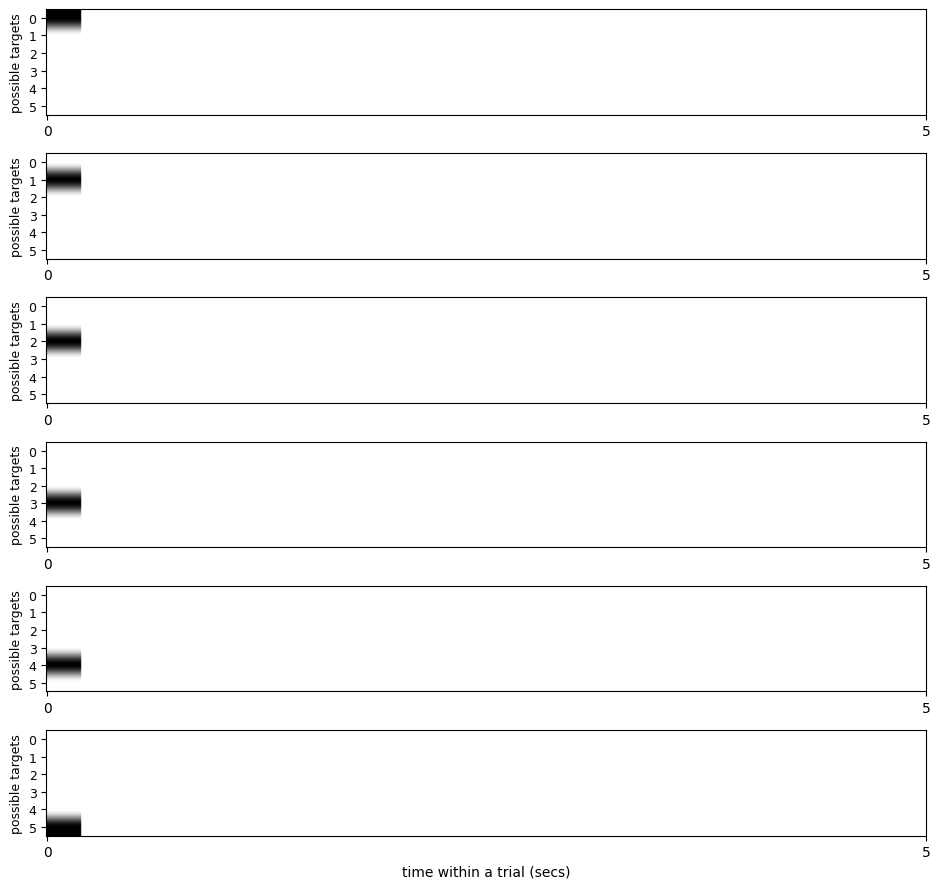

In [83]:
# @title Create stimuli and targets

# create stimuli and plot
stimulus = create_reaching_task_stimuli(tsteps, pulse_length, n_targets=targets, twod=False)
plot_reaching_task_stimuli(stimulus, targets, tsteps, T)

# create target (targets x timesteps x 2D coordinates) and plot
# target = create_reaching_task_targets(
#     tsteps,
#     pulse_length,
#     n_targets=targets,
#     stype=stimulus_type,
#     target_max=target_max
#     )
target = create_reaching_task_targets_trials(
    tsteps,
    pulse_length,
    n_targets=targets,
    learning_trials = n_learning1_trials,
    stype=stimulus_type,
    target_max=target_max
    )
plot_reaching_task_targets(target, tsteps, T)


# test_target = create_reaching_task_targets_test(
#     tsteps,
#     pulse_length,
#     n_targets=targets,
#     stype=stimulus_type,
#     target_max=target_max
#     )
# plot_reaching_task_targets(test_target, tsteps, T)


Loss in Trial 1 is 1.13201
Loss in Trial 2 is 0.14141
Loss in Trial 3 is 0.10249
Loss in Trial 4 is 2.29369
Loss in Trial 5 is 0.32926


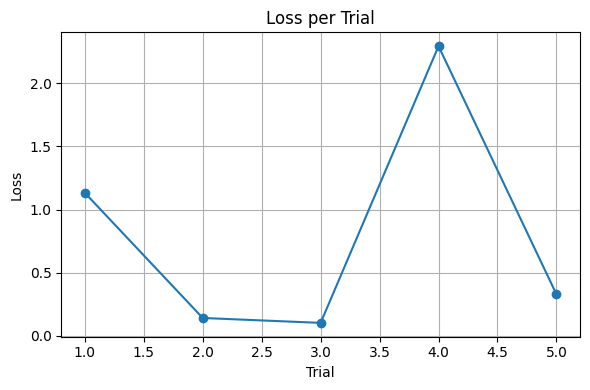

In [74]:
# @title build and train the network
# create and save RNN encoder
reaching_network = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
save_RNN(reaching_network, savedir)

# create feedforward decoder from RNN to (x,y) output units
reaching_decoder = create_reaching_task_decoder(reaching_network,
                                                n_output_units=N_OUTPUT_UNITS)

# create feedback weights from (x,y) output units back to RNN
reaching_feedback = get_feedback_weights(reaching_decoder)

# train and save the RNN encoder weights (learn the task)
reaching_loss = reaching_network.relearn(n_learning1_trials, stimulus,
                                         pulse_length, reaching_decoder,
                                         reaching_feedback, target, delta=delta, wplastic = None)
plot_loss_over_trials(reaching_loss)
np.save(f'{savedir}W_stabilized_reaching', reaching_network.W)
w1_reaching = reaching_network.W.copy()

# get the RNN's manifold
manifold_out = get_manifold(reaching_network)

# train the decoder
W_bci4, l4 = train_reaching_decoder(manifold_out["xi2"][:, :, :reduced_dim],
                                    target[:, pulse_length:, :],
                                    manifold_out["order"],
                                    n_output_units=N_OUTPUT_UNITS)

# transform
transformed = transform_reaching(reaching_network, manifold_out,
                                 W_bci4, n_output_units=N_OUTPUT_UNITS)

In [75]:
# @title Save run data
# format and save data for this run
run_data = {
    'params':{
        'dt':dt,
        'T':T,
        'time':time,
        'tsteps':tsteps,
        'pulse_length':pulse_length,
        'manifold_trials':manifold_trials,
        'target_max':target_max,
        'stimulus_type':stimulus_type,
        'N':N,
        'tau':tau,
        'g':g,
        'p':p
        },
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{
        'learning_trials':n_learning1_trials,
        'delta':delta,
        'decoder':reaching_decoder,
        'feedback':reaching_feedback,
        'stabilize_loss':reaching_loss
        },
    'manifold':{
        'activity':manifold_out["activity"],
        'activity2':manifold_out["activity_reshaped"],
        'xi':manifold_out["xi"],
        'xi2':manifold_out["xi2"],
        'cov':manifold_out["cov"],
        'ev':manifold_out["ev"],
        'evec':manifold_out["evec"],
        'pr':manifold_out["pr"],
        'order': manifold_out["order"]
        },
    'decoding':{
        'reduced_dim': reduced_dim,
        'weights': W_bci4,
        'loss':l4
        }
        }
np.save(f'{savedir}reaching_experiment_results', run_data)

# save manifold data separately
save_reaching_manifold(run_data, transformed)

In [76]:
# @title simulate_reaching
def simulate_reaching(savdir, dt):

  # set plot parameters
  COL_ORIG = 'k'
  ALPHA = 1

  # Load velocity (manifold) data from relearning run
  data = np.load(savdir + 'reaching_relearning_results.npy', allow_pickle=True).item()

  # Load full experimental data (with targets)
  data_target = np.load(savdir + 'reaching_experiment_results.npy', allow_pickle=True).item()

  # Extract activity and projection weights
  activity = data['manifold']['original']['activity2']              # shape: (trials * timesteps, N)
  # o_original = activity @ data['perturbations']['transformed'].T
  weights = data['perturbations']['transformed']        # shape: (2, N)
  o_original = activity @ weights.T                     # shape: (trials * timesteps, 2)

  # Reshape for plotting
  manifold_trials = data_target['params']['manifold_trials']
  tsteps = data_target['params']['tsteps']
  # pos_original = np.zeros((manifold_trials, tsteps, 2))
  # activity_reshaped = o_original.reshape(manifold_trials, tsteps, 2)

  # reconstruct trajectories from velocities
  pos_original = np.zeros(o_original.shape)
  for j in range(1, activity.shape[1]):  # start at 1 to use j-1 safely
    pos_original[:, j, :] = pos_original[:, j-1, :] + o_original[:, j, :] * dt

  start_points = pos_original[:, 0, :]  # shape (trials x 2)

  # Get targets
  target_traj = data_target['target']  # shape (n_targets, tsteps, 2)
  target_positions = target_traj[:, -1, :]  # final position for each target

  # Plot trajectories
  plt.figure(figsize=(15, 10), dpi=96)
  plt.subplot(2, 3, 3)

  for j in range(manifold_trials):
    plt.plot(pos_original[j, :, 0], pos_original[j, :, 1], COL_ORIG, alpha=ALPHA)

  # Plot dashed lines from start to target
  for j in range(manifold_trials):
    target_idx = j % target_positions.shape[0]
    plt.plot([start_points[j, 0], target_positions[target_idx, 0]],
             [start_points[j, 1], target_positions[target_idx, 1]],
             'r--', alpha=0.5)

  # Plot all target positions as red circles
  for tx, ty in target_positions:
    plt.plot(tx, ty, 'ro', markersize=10)

  plt.title('simulated reaching')
  plt.xlabel('x-position on screen')
  plt.ylabel('y-position on screen')
  plt.tight_layout()
  plt.show()

### Simulate Reaching

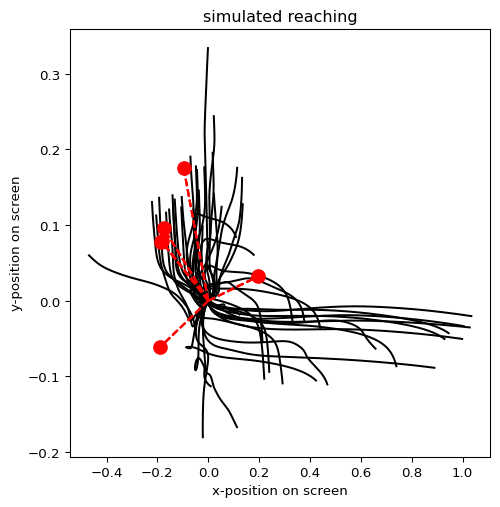

In [77]:
# @title Model Reaching Performance
trajectories = simulate_reaching(savedir, dt)

## Create task 2: "force"

Don't hesitate to use some of the utils functions that have been implemented for this tasks under the "force" task section.

Can you think of other tasks to test?